## Merge 2 dataset (weather + energy)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# load datasets
energy23_data = pd.read_csv('demanddata_2023.csv')
energy24_data = pd.read_csv('demanddata_2024.csv')
energy25_data = pd.read_csv('demanddata_2025.csv')
weather_data  = pd.read_csv('london_2023_25_halfhour_interp.csv')

# combine energy data
energy_data = pd.concat([energy23_data, energy24_data, energy25_data], ignore_index=True)

# convert time columns into proper UK timezone
# energy data is in local UK time (GMT/BST)
energy_data['SETTLEMENT_DATE'] = (
    pd.to_datetime(energy_data['SETTLEMENT_DATE'])
      .dt.tz_localize('Europe/London', ambiguous='NaT', nonexistent='shift_forward')
)

# weather data usually comes in UTC, so we localize to UTC then convert to UK
weather_data['time'] = (
    pd.to_datetime(weather_data['time'], utc=True)
      .dt.tz_convert('Europe/London')
)

# create full datetime for energy half-hour periods (already localized)
energy_data['datetime'] = (
    energy_data['SETTLEMENT_DATE'] +
    pd.to_timedelta((energy_data['SETTLEMENT_PERIOD'] - 1) * 30, unit='min')
)

# date range
start_date = pd.to_datetime("2023-01-01").tz_localize('Europe/London')
end_date   = pd.to_datetime("2025-10-31").tz_localize('Europe/London')

# filter energy data
energy_data = energy_data[
    (energy_data['datetime'] >= start_date) &
    (energy_data['datetime'] <= end_date)
]

# filter weather data
weather_data = weather_data[
    (weather_data['time'] >= start_date) &
    (weather_data['time'] <= end_date)
]

# merge datasets
merged_data = pd.merge(
    energy_data,
    weather_data,
    left_on='datetime',
    right_on='time',
    how='inner'
)

# save result
merged_data.to_csv('merged_energy_weather_data.csv', index=False)

C:\Users\GF63 Thin\AppData\Local\Temp\ipykernel_3984\3716731193.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(energy_data['SETTLEMENT_DATE'])


In [15]:
#get data
df=pd.read_csv('merged_energy_weather_data.csv')

In [16]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert("Europe/London")
df = df.sort_values('datetime').reset_index(drop=True)

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['year'] = df['datetime'].dt.year
#weekday 0=mon 6=sun
df['weekday'] = df['datetime'].dt.weekday
#weekend flag ie 1=sat/sun 0=mon-fri
df['is_weekend']=df['weekday'].apply(lambda x: 1 if x>=5 else 0)

## EDA

In [ ]:
# 1. check missing values

In [5]:
df.isnull().sum()

,0
SETTLEMENT_DATE,0
SETTLEMENT_PERIOD,0
ND,0
TSD,0
ENGLAND_WALES_DEMAND,0
EMBEDDED_WIND_GENERATION,0
EMBEDDED_WIND_CAPACITY,0
EMBEDDED_SOLAR_GENERATION,0
EMBEDDED_SOLAR_CAPACITY,0
NON_BM_STOR,0


In [ ]:
# 2. check duplicates

In [6]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# Select only rows with duplicated datetime
duplicate_rows = df[df['datetime'].duplicated(keep=False)]

#Duplicate SETTLEMENT_DATE and datetime
duplicate_rows[['SETTLEMENT_DATE', 'datetime']]




,SETTLEMENT_DATE,datetime


In [ ]:
# 3. check for impossible values eg negative energy demand or solar/wind generation

In [ ]:
#negative value for demand
demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

neg_demand=df[(df[demand_cols]<0).any(axis=1)]
print(f"Negative:          {len(neg_demand)} rows")

Negative:          0 rows


In [ ]:
#wind generation > capacity
exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

#solar generation> capacity
exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

print(f"Exceed Wind:          {len(exceed_wind)} rows")

print(f"Exceed Solar:          {len(exceed_solar)} rows")



Exceed Wind:          0 rows
Exceed Solar:          0 rows


In [ ]:
# Temperature spikes
temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# Wind spikes
wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

#Huminity
humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# pressure
pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# wind direction
wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# precipitation
precipitation_negative = df[df['precipitation'] < 0]

print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
print(f"Negative precipitation:           {len(precipitation_negative)} rows")



Temperature unrealistic:          0 rows
Wind speed unrealistic:           0 rows
Humidity invalid:                 0 rows
Pressure invalid:                 0 rows
Wind direction invalid:           0 rows
Negative precipitation:           0 rows


In [ ]:
#mismatch date and time
df['SETTLEMENT_DATE'] = (
    pd.to_datetime(df['SETTLEMENT_DATE'], utc=True)
      .dt.tz_convert("Europe/London")
)

settlement_dates = df['SETTLEMENT_DATE'].dt.date
datetime_dates   = df['datetime'].dt.date

mismatch = df[settlement_dates != datetime_dates]

print(mismatch[['SETTLEMENT_DATE', 'datetime']])



Empty DataFrame
Columns: [SETTLEMENT_DATE, datetime]
Index: []


In [ ]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

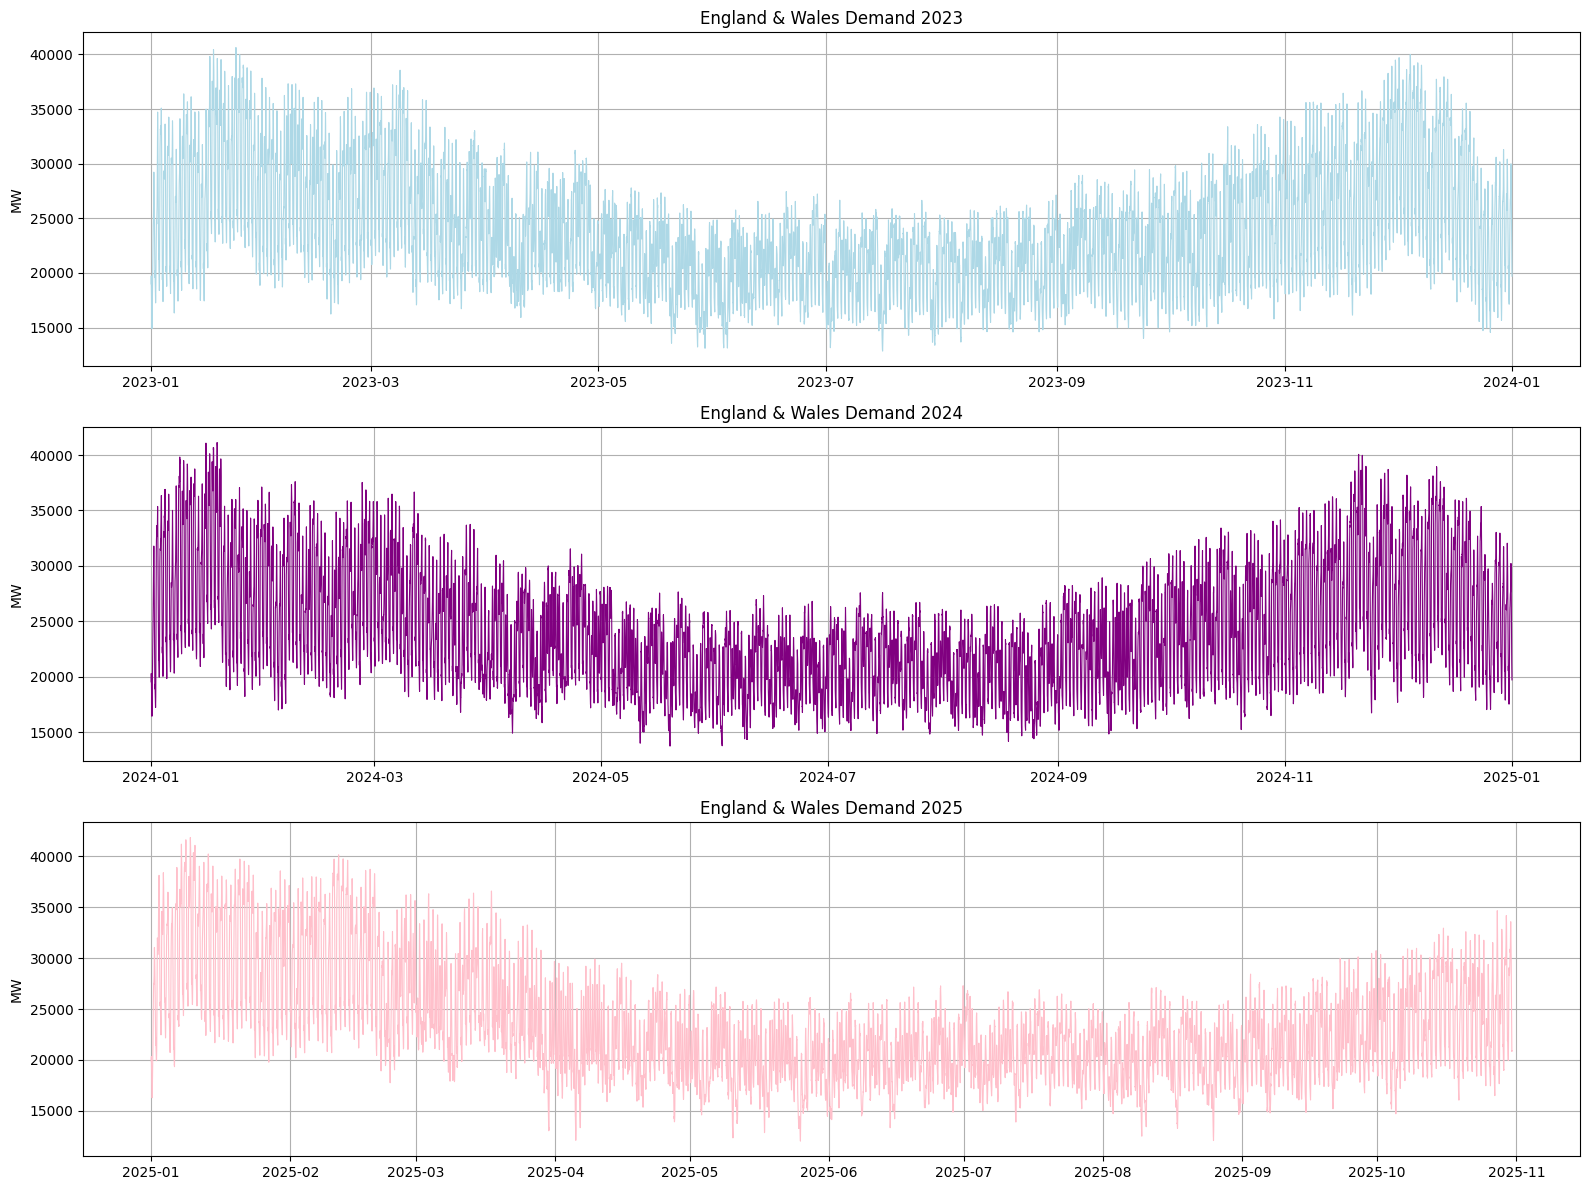

In [ ]:
import matplotlib.pyplot as plt

df_2023=df[df['datetime'].dt.year==2023]
df_2024=df[df['datetime'].dt.year==2024]
df_2025=df[df['datetime'].dt.year==2025]

fig,axes=plt.subplots(3,1,figsize=(16,12))

#2023
axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
axes[0].set_title('England & Wales Demand 2023')
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].grid(True)

#2024
axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
axes[1].set_title('England & Wales Demand 2024')
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].grid(True)

#2025
axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
axes[2].set_title('England & Wales Demand 2025')
axes[2].set_xlabel('')
axes[2].set_ylabel('MW')
axes[2].grid(True)

plt.tight_layout()
plt.show()

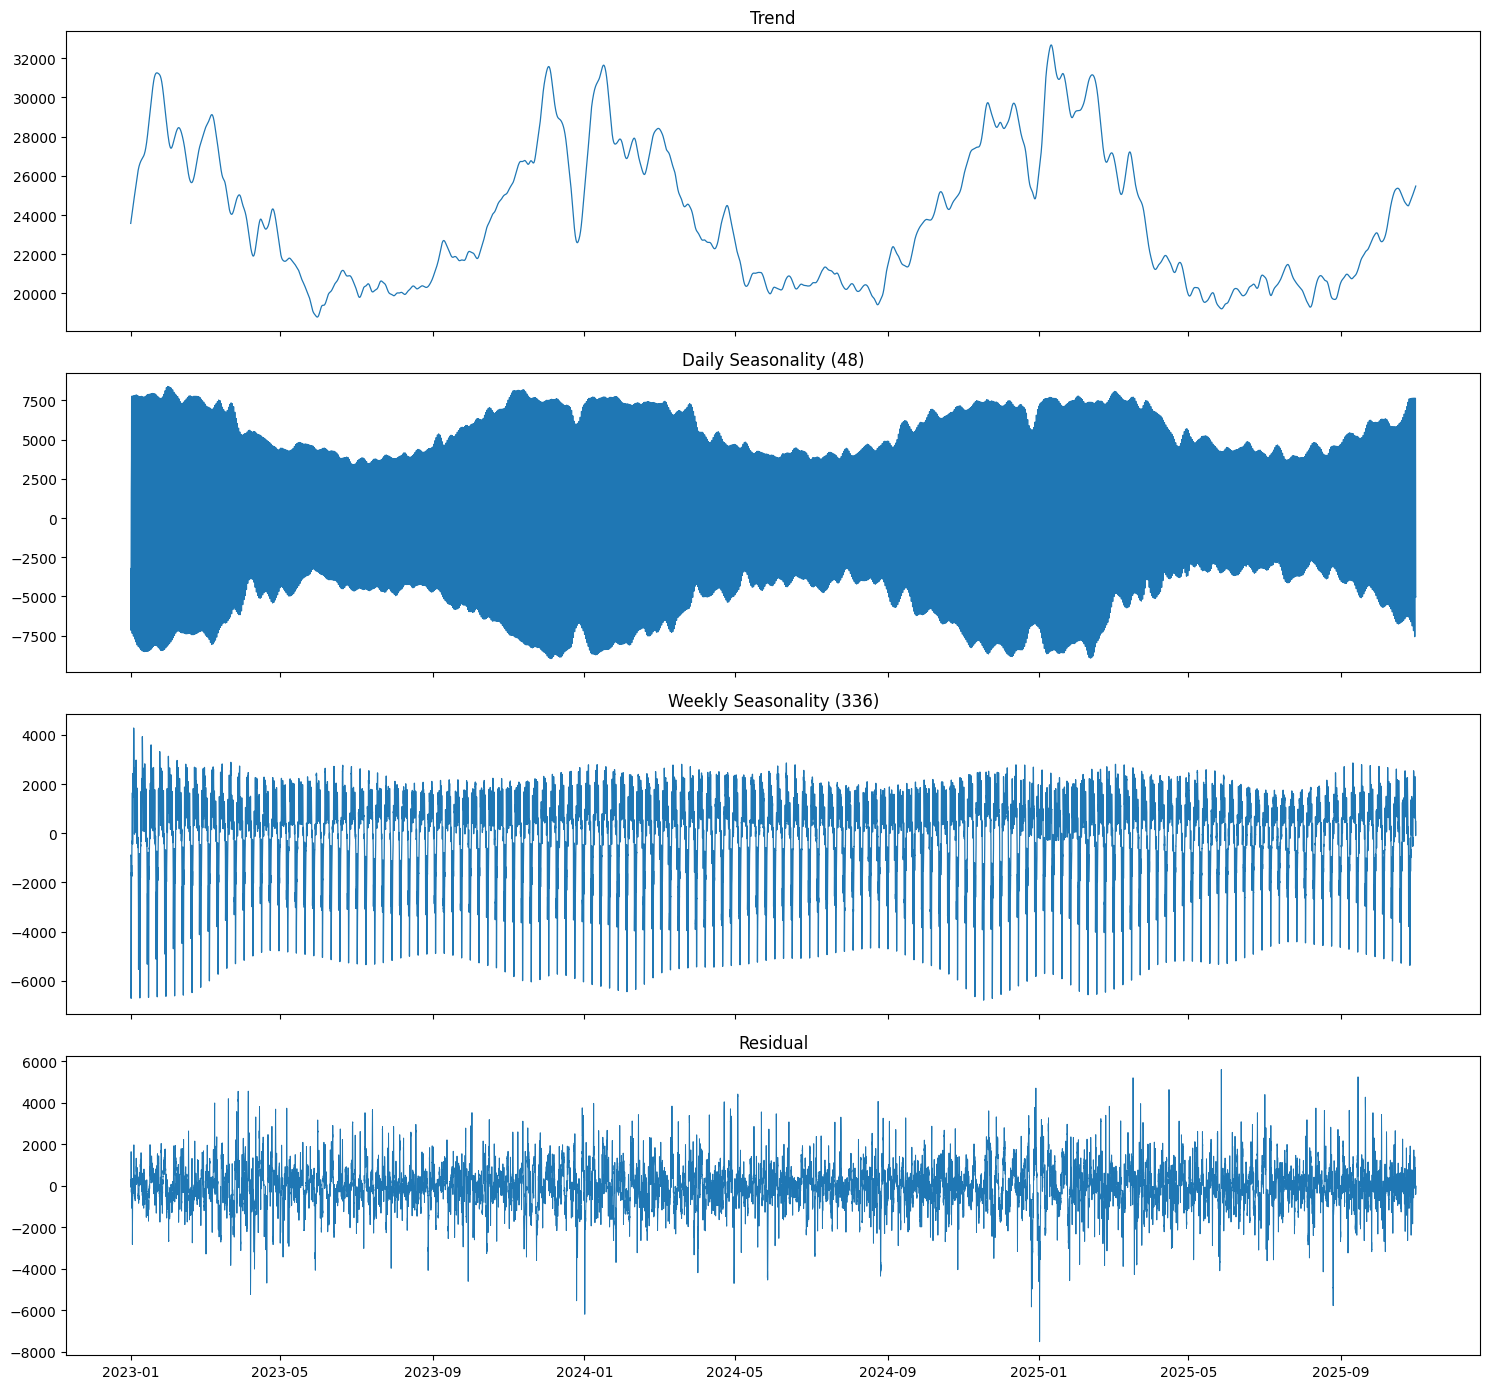

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL


df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_localize(None)
df = df.set_index('datetime')



ts = df['ENGLAND_WALES_DEMAND']

mstl = MSTL(
    ts,
    periods=[48, 336],
    stl_kwargs={
        "seasonal_deg": 1,
        "trend_deg": 1,
        "trend_jump": 5
    }
)

res = mstl.fit()


trend = res.trend
seasonal_daily = res.seasonal['seasonal_48']
seasonal_weekly = res.seasonal['seasonal_336']
residual = res.resid


fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

axes[0].plot(trend, linewidth=0.9)
axes[0].set_title('Trend')

axes[1].plot(seasonal_daily, linewidth=0.9)
axes[1].set_title('Daily Seasonality (48)')

axes[2].plot(seasonal_weekly, linewidth=0.9)
axes[2].set_title('Weekly Seasonality (336)')

axes[3].plot(residual, linewidth=0.7)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

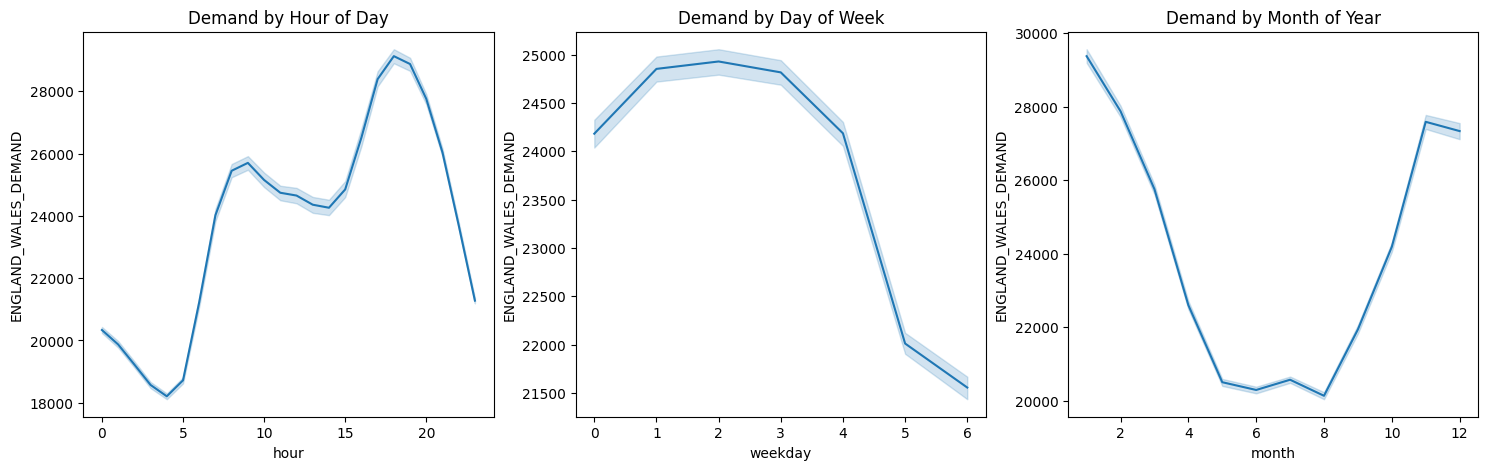

In [ ]:

fig,axes=plt.subplots(1,3,figsize=(18,5))
sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
axes[0].set_title('Demand by Hour of Day')
sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
axes[1].set_title('Demand by Day of Week')
sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
axes[2].set_title('Demand by Month of Year')
plt.tight_layout
plt.show()

In [ ]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

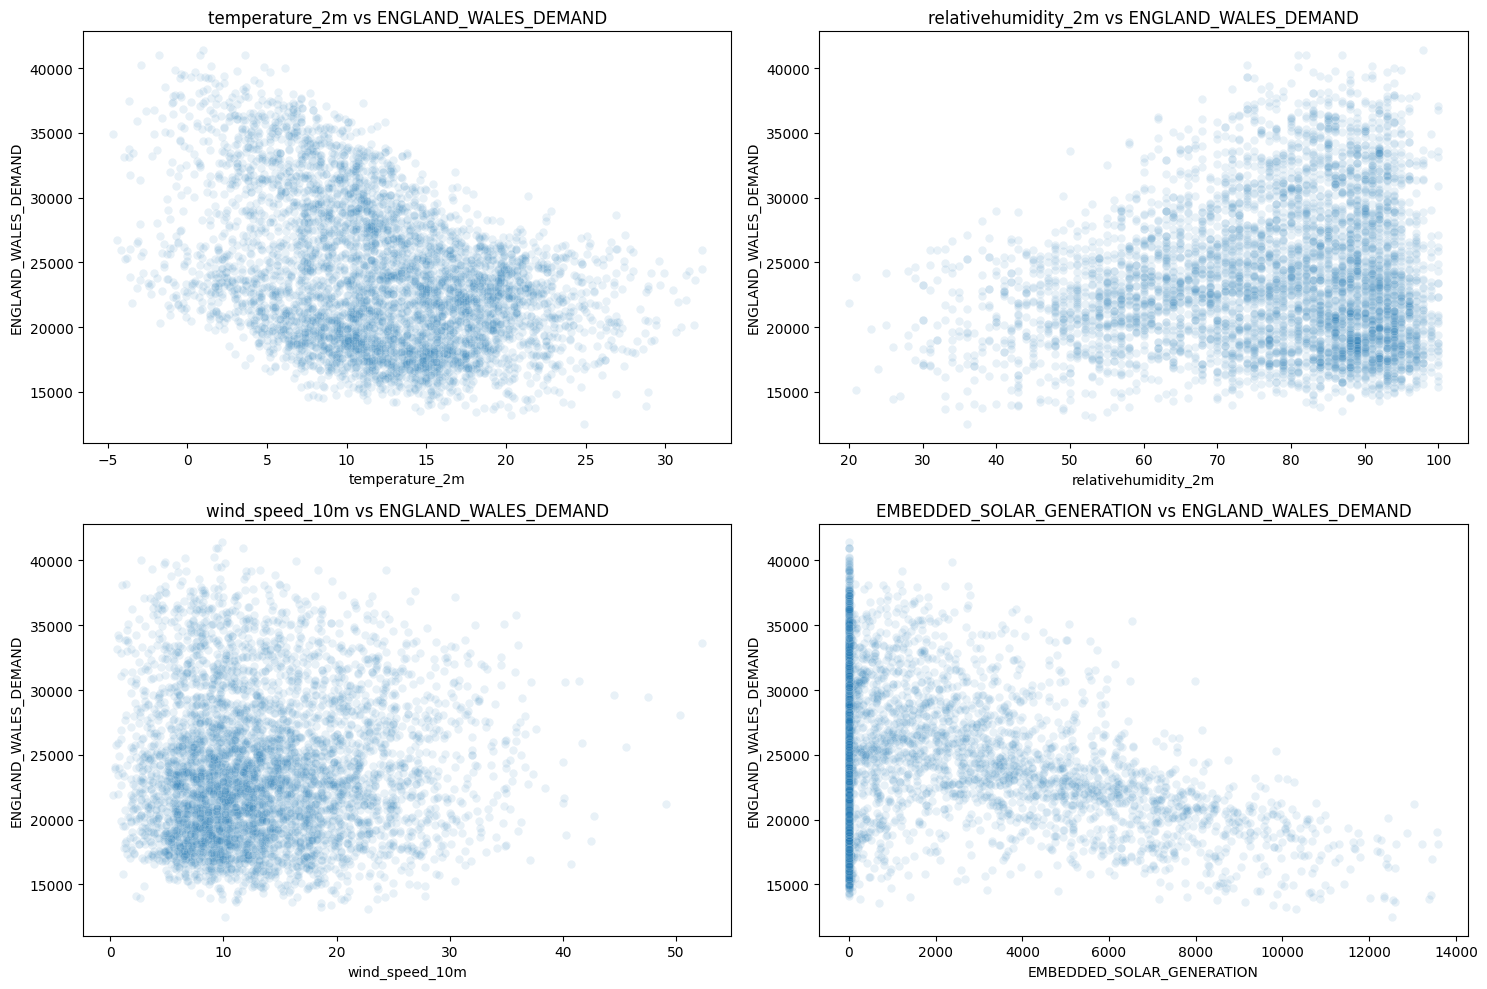

In [ ]:
weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
fig,axes=plt.subplots(2,2,figsize=(15,10))
axes=axes.flatten()
for i,col in enumerate(weather_vars):
    sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
    axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
plt.tight_layout()
plt.show()

In [ ]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [ ]:
# Select key variables
key_vars = [
    "ENGLAND_WALES_DEMAND",
    "EMBEDDED_WIND_GENERATION",
    "EMBEDDED_SOLAR_GENERATION",
    "NON_BM_STOR",
    "temperature_2m",
    "relativehumidity_2m",
    "pressure_msl",
    "wind_speed_10m",
    "wind_direction_10m",
    "precipitation"
]

# Filter only variables that actually exist in the dataframe
key_vars = [v for v in key_vars if v in df.columns]

# Compute summary statistics
summary = df[key_vars].agg(["mean", "median", "std", "min", "max"]).T   # .T --> transpose

# Print Summary
print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max):\n")
print(summary.round(2))





Summary Statistics (Mean, Median, Standard Deviation, Min, Max):

                               mean   median      std      min      max
ENGLAND_WALES_DEMAND       23791.38  22891.0  5472.45  12040.0  41835.0
EMBEDDED_WIND_GENERATION    1839.09   1516.0  1191.31    125.0   5962.0
EMBEDDED_SOLAR_GENERATION   1809.79     18.0  2786.53      0.0  14035.0
NON_BM_STOR                    0.00      0.0     0.01      0.0      2.0
temperature_2m                12.20     12.0     6.19     -5.0     33.6
relativehumidity_2m           77.14     81.0    15.47     17.0    100.0
pressure_msl                1014.83   1015.8    11.46    953.8   1046.0
wind_speed_10m                13.69     12.3     7.28      0.0     52.3
wind_direction_10m           190.12    218.0    92.03      1.0    360.0
precipitation                  0.09      0.0     0.35      0.0      9.7


In [ ]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

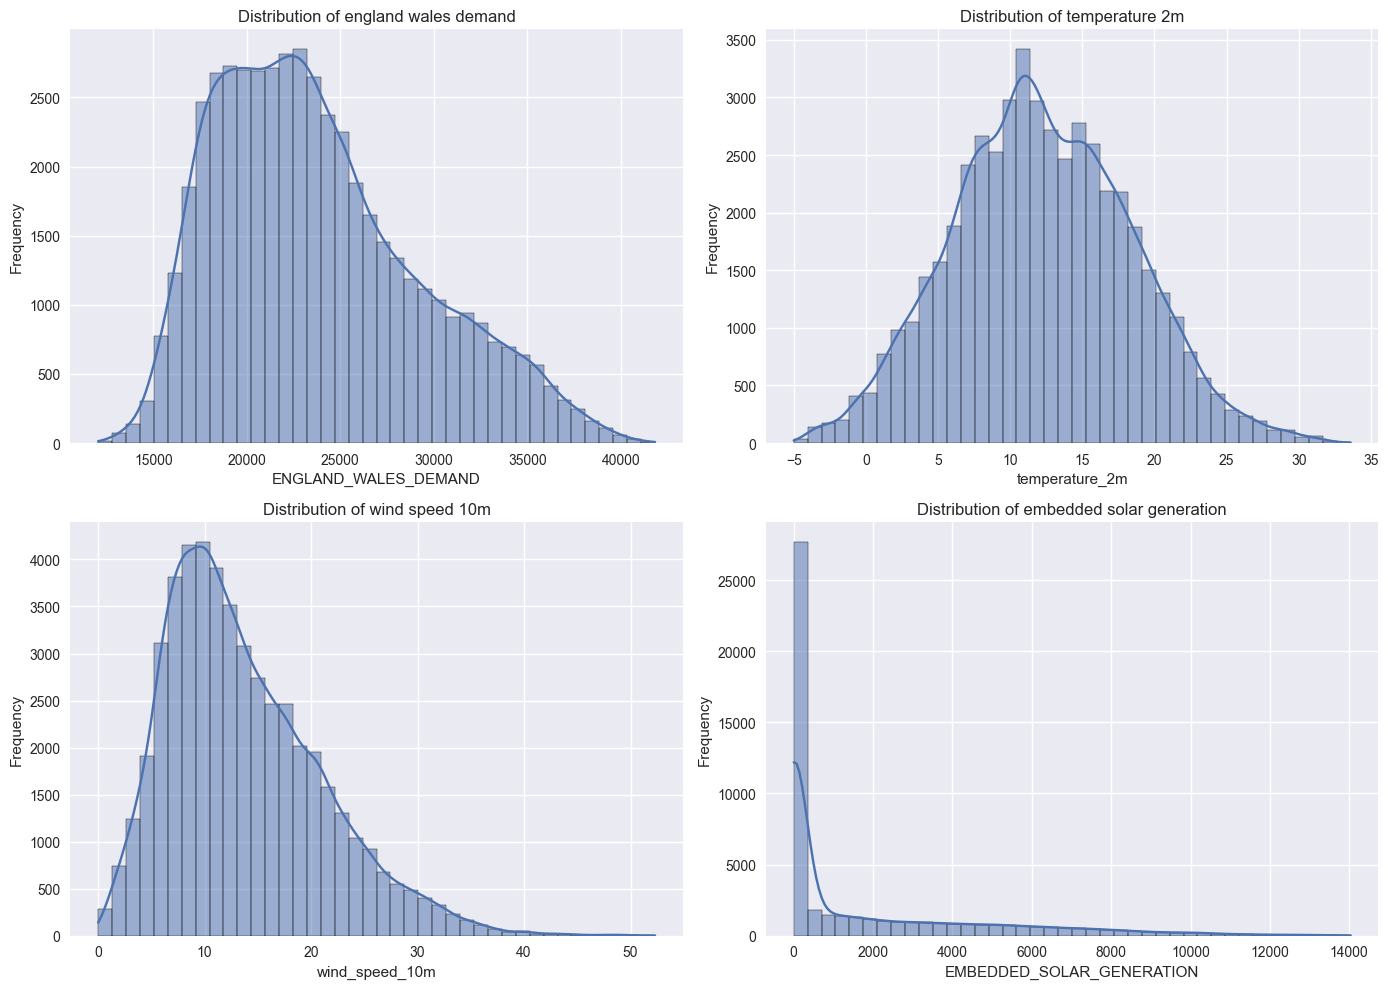

In [ ]:
# Select variables for distribution plots
dist_vars = [
    "ENGLAND_WALES_DEMAND",
    "temperature_2m",
    "wind_speed_10m",
    "EMBEDDED_SOLAR_GENERATION"   # using solar generation as solar radiation proxy
]

# Plot settings
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(14, 10))

for i, var in enumerate(dist_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=40)
    var_name = var.replace("_", " ").lower()
    plt.title(f"Distribution of {var_name}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

# wq:nid 1 or 3 box plot? cuz around 3 years


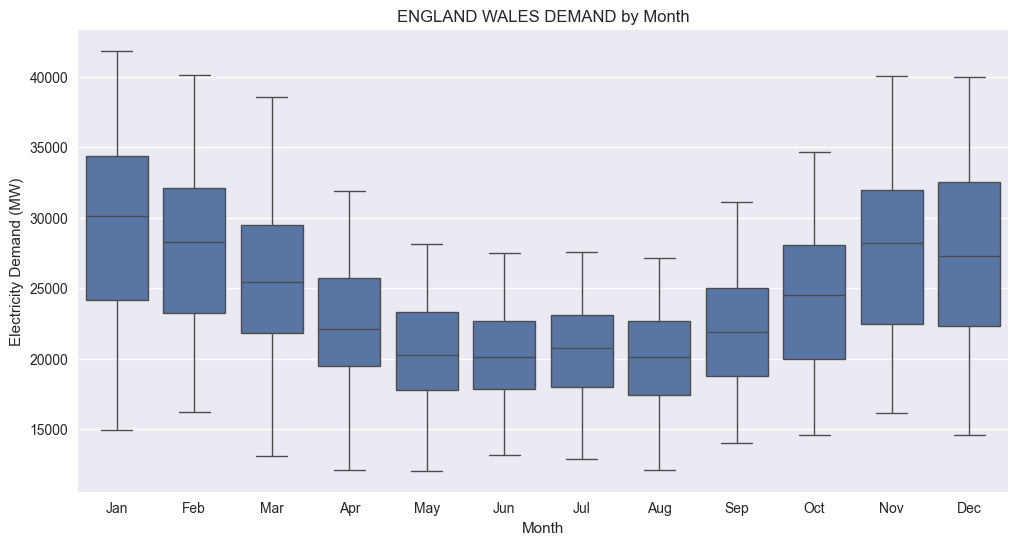

In [ ]:
# Ensure your datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from datetime
df['month'] = df['datetime'].dt.month

# Set plot style
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(x='month', y='ENGLAND_WALES_DEMAND', data=df)
plt.title('ENGLAND WALES DEMAND by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MW)')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

In [ ]:
# 10. correlation
# check pearson correlation between Demand and weather variables

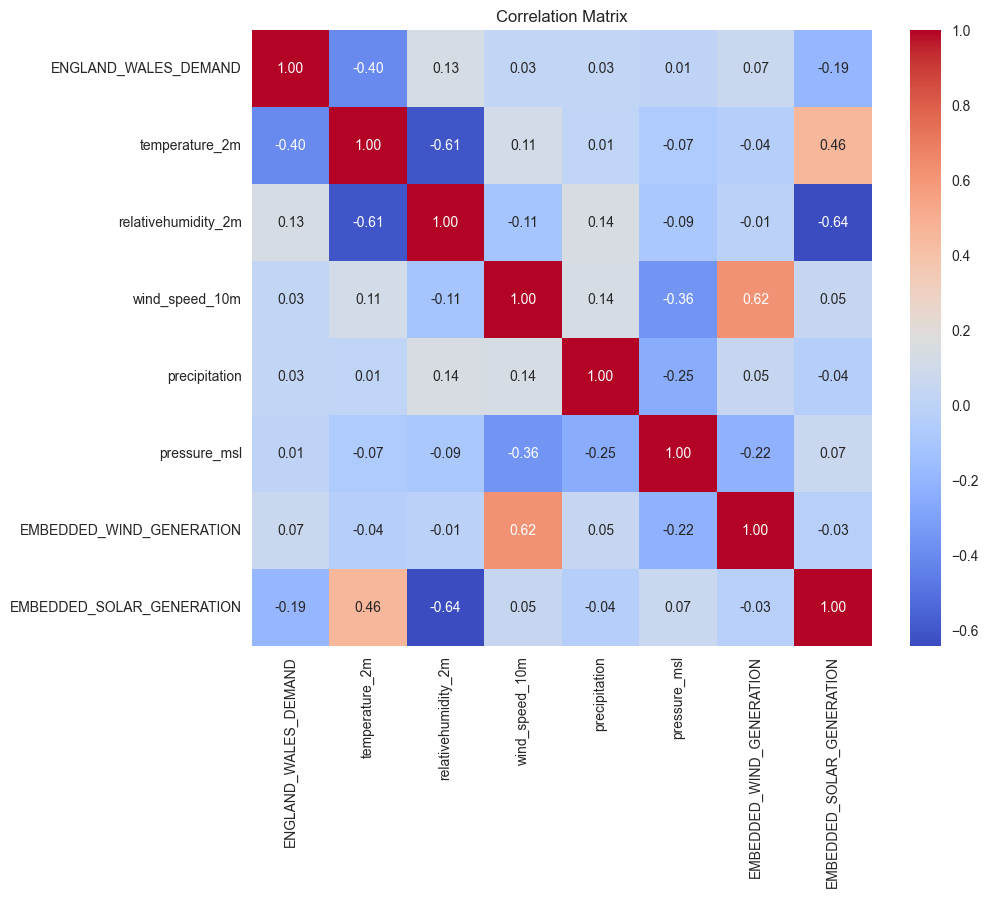

In [ ]:
corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [ ]:
from statsmodels.tsa.stattools import adfuller
series=df['ENGLAND_WALES_DEMAND'].dropna()
result=adfuller(series.iloc[:10000],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -2.8289607068160376
p-value: 0.05425453386695289
The time series is non-stationary.


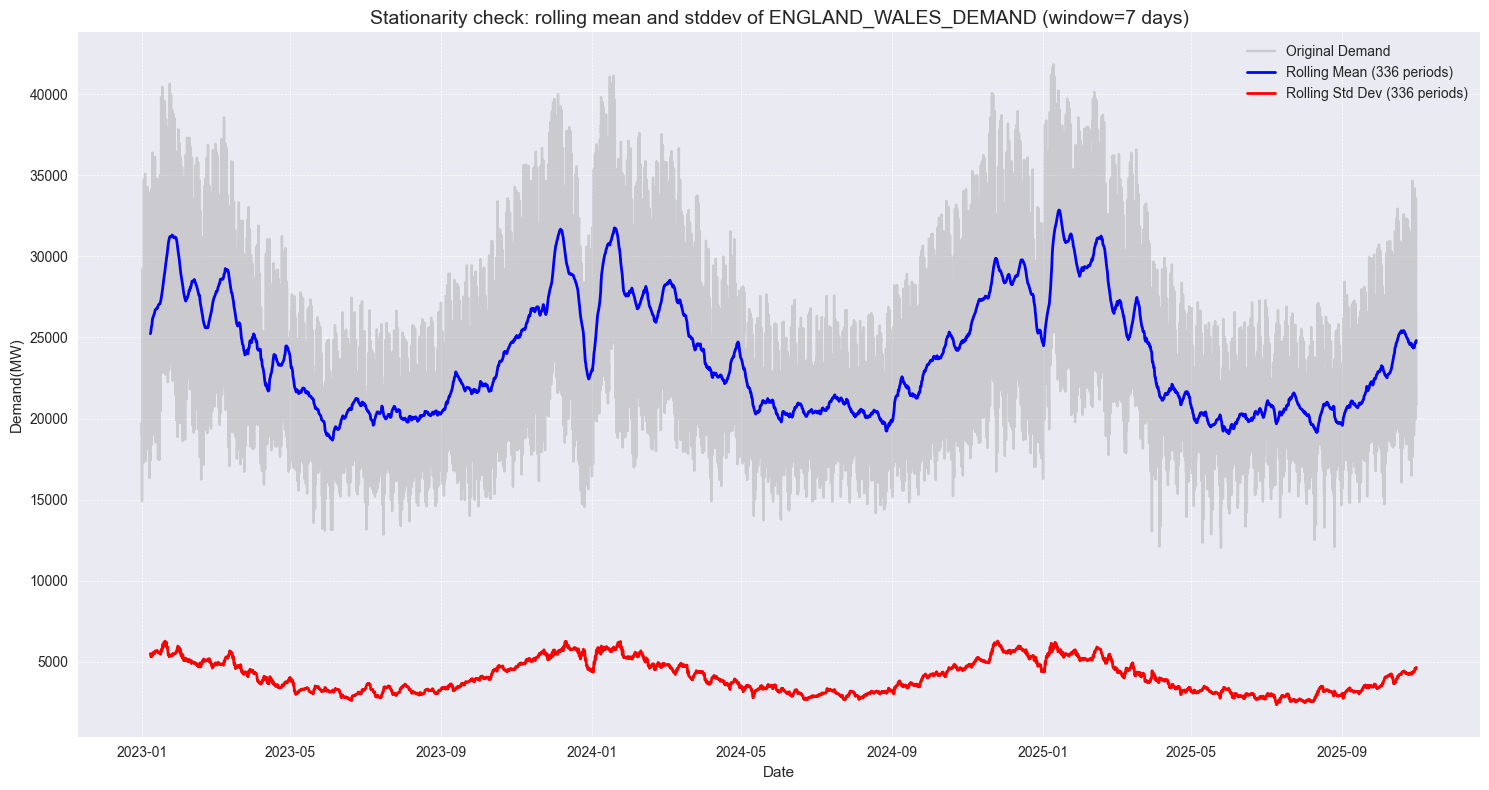

#remark
1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.
2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)
3.seasonality:repeating waves in rolling mean indicate seasonality


In [ ]:
target_col='ENGLAND_WALES_DEMAND'
window_size=48*7  # one week of half-hourly data

if 'datetime' not in df.columns:
    df = df.reset_index()

rolling_mean=df[target_col].rolling(window=window_size).mean()
rolling_std=df[target_col].rolling(window=window_size).std()


plt.figure(figsize=(15,8))
plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Demand(MW)')
plt.legend(loc='best')
plt.grid(True,which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("#remark")
print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
print("3.seasonality:repeating waves in rolling mean indicate seasonality")

## Part A

## Train test split

In [18]:
target = 'ENGLAND_WALES_DEMAND'

# Features
time_features = ['hour', 'day', 'month','year','is_weekend','weekday']
weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl',
                    'wind_speed_10m', 'wind_direction_10m', 'precipitation']
grid_features = [
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
    'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
    'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
    'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
    'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
    'VIKING_FLOW', 'GREENLINK_FLOW'
]

feature_cols = weather_features + time_features + grid_features

model_df = df.dropna(subset=feature_cols + [target]).copy()

In [19]:
#split based on the date time
#2023，2024
train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime")
print(train_df.head())

#2025
test_df=model_df[model_df.year==2025].sort_values("datetime")
print(test_df.head())

#train set
X_train=train_df[feature_cols]
y_train=train_df[target]

#test set
X_test=test_df[feature_cols]
y_test=test_df[target]

print(f"Train Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

                               SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  \
datetime                                                                   
2023-01-01 00:00:00  2023-01-01 00:00:00+00:00                  1  21043   
2023-01-01 00:30:00  2023-01-01 00:00:00+00:00                  2  21756   
2023-01-01 01:00:00  2023-01-01 00:00:00+00:00                  3  21348   
2023-01-01 01:30:00  2023-01-01 00:00:00+00:00                  4  20586   
2023-01-01 02:00:00  2023-01-01 00:00:00+00:00                  5  19781   

                       TSD  ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  \
datetime                                                                     
2023-01-01 00:00:00  24680                 18995                      2815   
2023-01-01 00:30:00  25289                 19730                      2793   
2023-01-01 01:00:00  25269                 19327                      2773   
2023-01-01 01:30:00  24574                 18589                      2753   

## LSTM

In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time
#from tensorflow.keras.optimizers import Adam
import os

class LSTM_Model:
    def __init__(self,input_shape, epoachs=50,batch_size=32):
        self.input_shape=input_shape
        self.epochs=epoachs
        self.batch_size=batch_size
        self.model=self.build_model()

    def build_model(self):
        model=Sequential()
        model.add(LSTM(50,activation='relu',input_shape=self.input_shape))
        model.add(Dense(1))
        model.compile(optimizer='adam',loss='mse')
        return model

    def fit_predict(self,X_train,y_train,X_test):
        start_train=time.time()
        self.model.fit(X_train,y_train, epochs=self.epochs,batch_size=self.batch_size,verbose=0)
        end_train=time.time()
        training_time=end_train-start_train

        start_pred=time.time()
        y_pred=self.model.predict(X_test).flatten()
        end_pred=time.time()
        inference_time = (end_pred - start_pred) / X_test.shape[0]

        return y_pred,training_time,inference_time

    def get_model_size(self):
        temp_path="temp_lstm_model.keras"
        self.model.save(temp_path)
        size_mb=os.path.getsize(temp_path)/1e6
        os.remove(temp_path)
        return size_mb






## Train Models

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
import warnings
import time
import pickle


models={
    "Linear Regression":LinearRegression(),
     "Random Forest":RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1),
     "XGBoost":XGBRegressor(n_estimators=100,random_state=42,n_jobs=-1),
     "LSTM" : "LSTM"
}

results_list=[]
predictions={}
for model_name,model in models.items():
    print(f"Training {model_name}...")


    if model_name=="LSTM":
        X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        lstm=LSTM_Model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))

        y_pred,train_time,inference_time=lstm.fit_predict(X_train_lstm,y_train.values,X_test_lstm)

        model_size_mb=lstm.get_model_size()
        predictions[model_name] = y_pred



    else:
        start_train=time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train,y_train)
        end_train=time.time()
        train_time=end_train-start_train

        sample_X = X_test[:1000] if len(X_test) > 1000 else X_test
        start_pred = time.time()
        y_pred=model.predict(X_test)
        end_pred = time.time()
        inference_time = (end_pred - start_pred) / len(sample_X)  # per sample
        full_pred = model.predict(X_test)  # full prediction for metrics
        predictions[model_name] = full_pred

        model_bytes = pickle.dumps(model)
        model_size_mb = len(model_bytes) / 1e6


    mae=mean_absolute_error(y_test,y_pred)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    r2=r2_score(y_test,y_pred)
    mape=mean_absolute_percentage_error(y_test,y_pred)

    results_list.append({
        "Model":model_name,
        "MAE":mae,
        "MSE":mse,
        "RMSE":rmse,
        "R2":r2,
        "MAPE":mape,
        "Training Time (s)":train_time,
        "Inference Time per Sample (s)":inference_time,
        "Model Size (MB)":model_size_mb
    })

results_df=pd.DataFrame(results_list)
print("\nModel comparison:")
print(results_df)

Training Linear Regression...
Training Random Forest...
Training XGBoost...
Training LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Model comparison:
               Model           MAE           MSE          RMSE        R2  \
0  Linear Regression  13742.165003  2.330029e+08  15264.431133 -6.870027   
1      Random Forest   1228.089238  2.609699e+06   1615.456138  0.911853   
2            XGBoost   1288.682007  2.690370e+06   1640.234816  0.909129   
3               LSTM   3160.186768  1.564811e+07   3955.769584  0.471461   

       MAPE  Training Time (s)  Inference Time per Sample (s)  Model Size (MB)  
0  0.651749           0.090218                       0.000005         0.001415  
1  0.053947          71.800056                       0.000303       318.746777  
2  0.054946           1.133104                       0.000058         0.479221  
3  0.137254         162.721110                       0.000087         0.216786  


## Error Analysis


=== Plotting diagnostics for Linear Regression ===


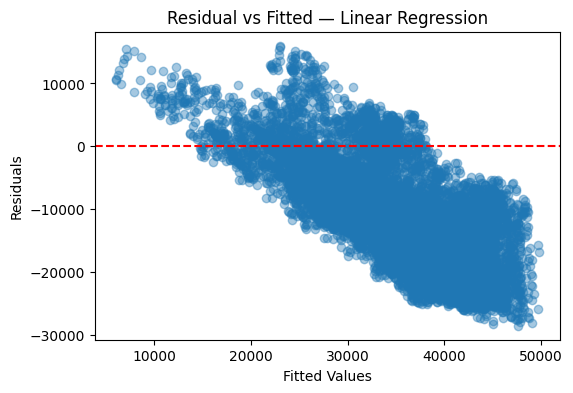

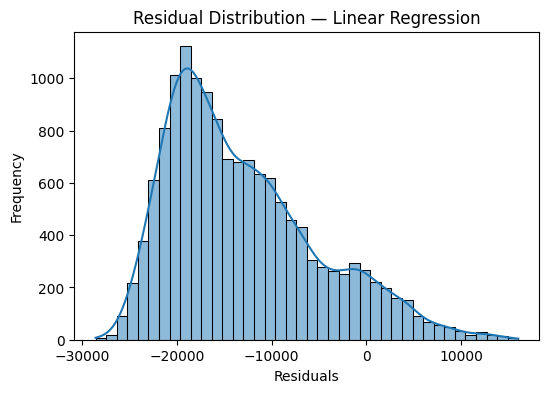


=== Plotting diagnostics for Random Forest ===


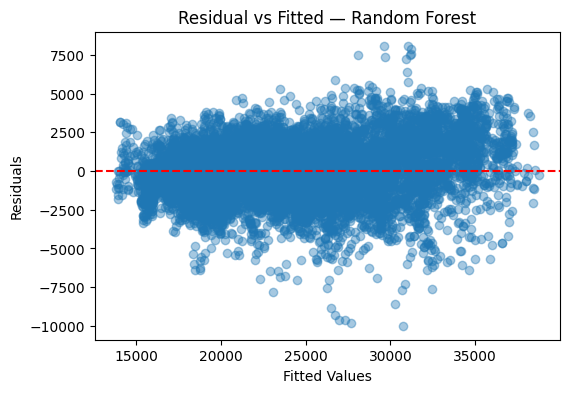

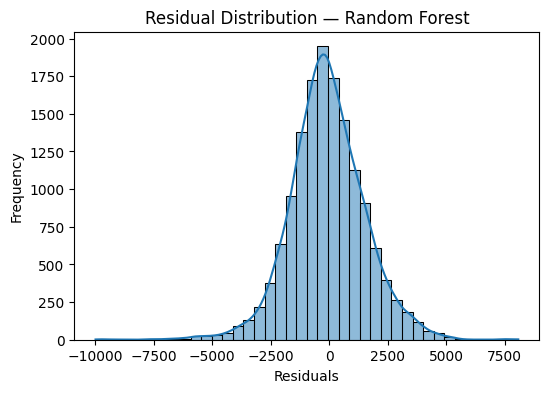


=== Plotting diagnostics for XGBoost ===


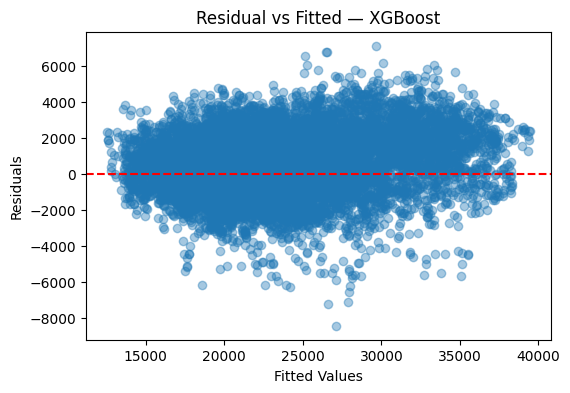

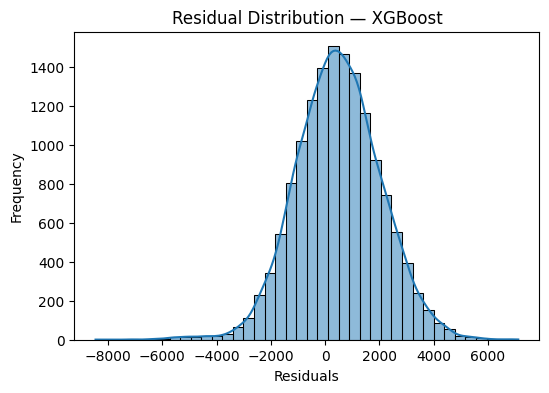


=== Plotting diagnostics for LSTM ===


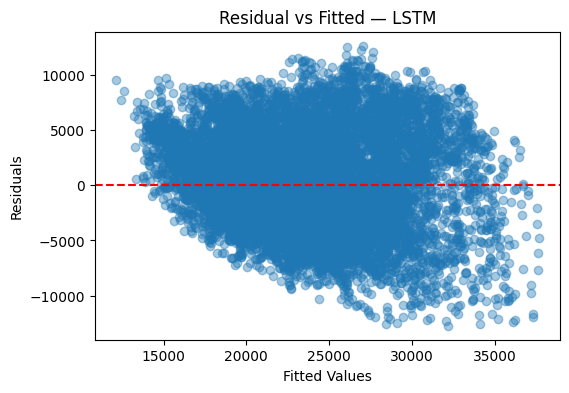

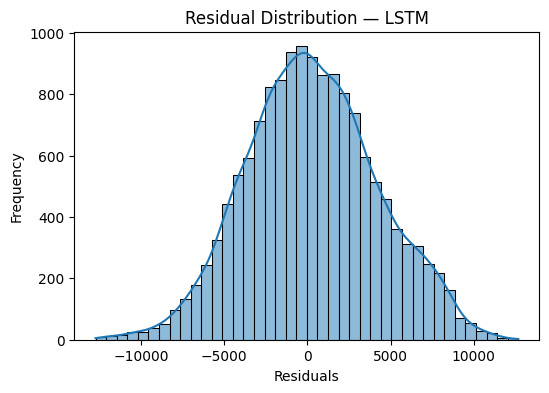

In [25]:
for model_name, y_pred in predictions.items():
    print(f"\n=== Plotting diagnostics for {model_name} ===")

    residuals = y_test.values - y_pred

    # -------------------------------------
    # 1. Residual vs Fitted
    # help to detect: non-linearity,heteroscedasticity,outliers,wrong functional form/model bias

    # if residual plot looks:
    # scattered and no pattern, means model is good
    # curved, means model not sufficiently non-linear
    # funnel shaped, means variance is unstable
    # a bunch of points far away, means outliers
    # uneven above/below means bias
    # -------------------------------------
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.4)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual vs Fitted — {model_name}")
    plt.show()

    # -------------------------------------
    # 2. Residual Distribution
    # -------------------------------------
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, bins=40, kde=True)
    plt.title(f"Residual Distribution — {model_name}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()




    # worst case 20 samples, error vs time, error by segments, error-feature correlation not yet done

## Feature importance RF/XGB/linear regression

## Part B

## feature engineering

## Hyperparameter tuning